In [17]:
import cupy as cp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os
import pickle
import sys


sys.path.append(os.path.join(os.getenv("HOME"), "gpuaffman_networks/"))
import general_network_visualization, parralel_and_task_evolution, ragged_task_evolution, ragged_general_network
from genetics import analysis_util

In [18]:
k_3_results = "boolean_network_data/parralel_and_evolution_results/2023-02-17-11-14-27"
#other_results = "boolean_network_data/parralel_and_evolution_results/2023-02-15-13-18-54"

In [19]:
data_dir = os.path.join(os.getenv("HOME"), k_3_results)
best_error = np.load(os.path.join(data_dir, "best_errors.npy"))
with open(os.path.join(data_dir,"best_populations.pk"), "rb") as f:
    populations = pickle.load(f)


In [20]:
N = populations[0][0].shape[0]
input_state = cp.asnumpy(parralel_and_task_evolution.make_pnand_input_state(N))
batched_input_state = np.broadcast_to(np.expand_dims(np.expand_dims(input_state, 1), 1), (input_state.shape[0], len(populations), 1, N)).astype(np.bool_)
best_functions = np.expand_dims(np.stack([x[0] for x in populations], axis=0), 1).astype(np.bool_)
best_conn = np.expand_dims(np.stack([x[1] for x in populations], axis=0), 1).astype(np.int16)
best_used_conn = np.expand_dims(np.stack([x[2] for x in populations], axis=0), 1).astype(np.bool_)

In [21]:
best_functions, best_conn, best_used_conn, sorted_perfs =  analysis_util.sort_by_performance(batched_input_state, best_functions, best_conn, best_used_conn, parralel_and_task_evolution.evaluate_pnand_task)

In [22]:
import importlib
importlib.reload(general_network_visualization)
graphs = [general_network_visualization.influence_graph_from_ragged_spec(f[0, :, :], c[0, :, :], uc[0, :, :]) for f, c, uc in zip(best_functions, best_conn, best_used_conn)]

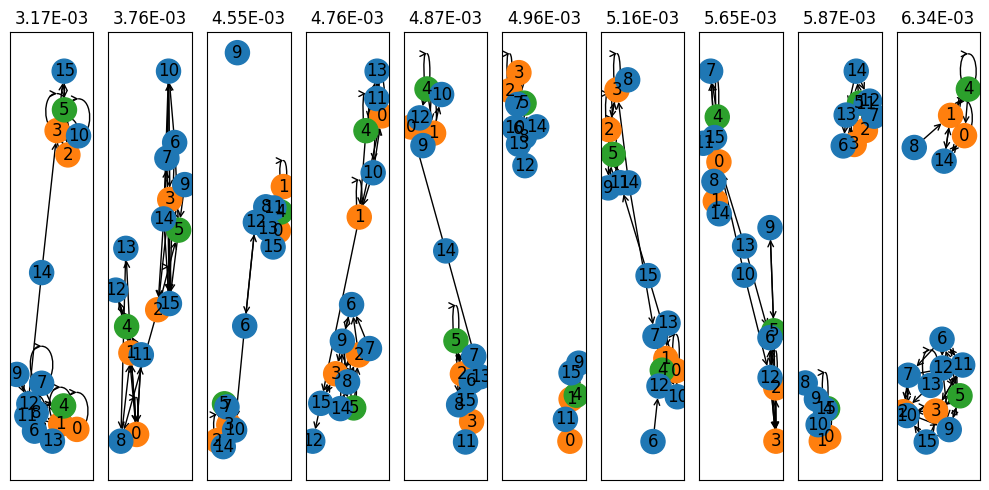

In [23]:
import importlib
importlib.reload(general_network_visualization)
best_to_plot = 10
to_plot = graphs[:best_to_plot]
fig, axs = plt.subplots(ncols=len(to_plot), figsize=(10,5))
node_colors = ["C0"] * N
node_colors[0] = "C1"
node_colors[1] = "C1"
node_colors[2] = "C1"
node_colors[3] = "C1"
node_colors[4] = "C2"
node_colors[5] = "C2"


for g, ax, err in zip(graphs, axs, sorted_perfs[:best_to_plot]):
    pos = nx.spring_layout(g)
    general_network_visualization.plot_network_directed(g, pos, ax, node_colors)
    ax.set_title("{:.2E}".format(err))
fig.tight_layout()

In [18]:
influence = analysis_util.compute_influence(best_functions[:2, 0, ...])

In [30]:
example_trajs, example_noise = analysis_util.run_dynamics_forward_save_state(batched_input_state, best_functions, best_conn, best_used_conn, 10, 0)
example_trajs = np.squeeze(example_trajs, -2)
example_noise = np.squeeze(example_noise, -2)

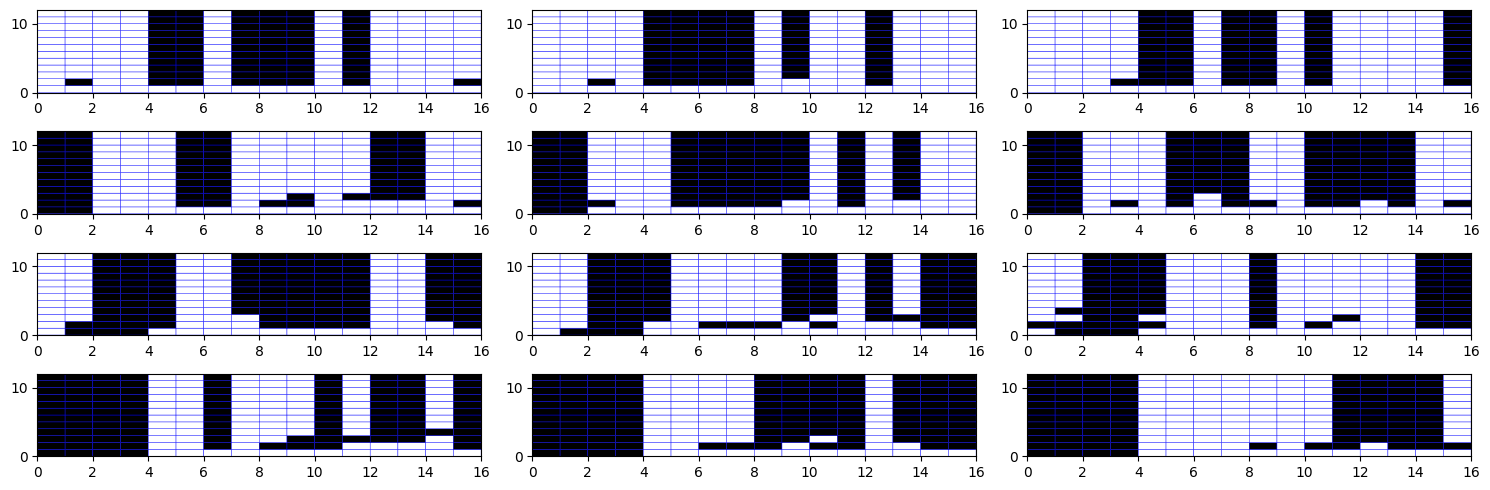

In [31]:
to_plot = [0, 3, -2, -1]
fig, axs = plt.subplots(nrows=len(to_plot), ncols=best_to_plot, figsize=(15, 5))
for i in range(best_to_plot):
    for j, k in enumerate(to_plot):
        axs[j, i].pcolor(example_trajs[:, k, i, :], cmap="Greys", linewidth=0.3, edgecolors="blue")
fig.tight_layout()

In [22]:
physical_error_rates = np.linspace(start=0, stop=0.01, num=20)
logical_error_rates = analysis_util.generate_ft_curve(physical_error_rates, batched_input_state, best_functions, best_conn, best_used_conn, parralel_and_task_evolution.evaluate_pnand_task, n_traj=5000)

KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots()
logical_error_rates = np.array(logical_error_rates)
for j in range(best_to_plot):
    axs.plot(physical_error_rates, logical_error_rates[:, j], label="{}".format(j))
axs.set_xlabel("Physical Error Rate")
axs.set_ylabel("Logical Error Rate")
axs.legend()
